In [ ]:
from google.colab import  files
uploaded = files.upload()


Saving ecommerce1.csv to ecommerce1.csv


In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv("ecommerce1.csv", encoding="ISO-8859-1")

# Drop duplicates
df = df.drop_duplicates()

# Drop rows with missing 'CustomerID' or 'Description'
df = df.dropna(subset=["CustomerID", "Description"])

# Remove rows with non-positive Quantity or UnitPrice
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Reset index
df.reset_index(drop=True, inplace=True)

print("Cleaned dataset shape:", df.shape)


Cleaned dataset shape: (392692, 8)


In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Encode categorical variables
le_stock = LabelEncoder()
df['StockCodeEncoded'] = le_stock.fit_transform(df['StockCode'])

le_country = LabelEncoder()
df['CountryEncoded'] = le_country.fit_transform(df['Country'])

# Calculate TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Normalize numerical features
scaler = MinMaxScaler()
df[['UnitPrice', 'TotalPrice']] = scaler.fit_transform(df[['UnitPrice', 'TotalPrice']])

# Sort by date for time-series modeling
df = df.sort_values(by='InvoiceDate')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load and clean the dataset
df = pd.read_csv("ecommerce1.csv", encoding="ISO-8859-1")
df = df.drop_duplicates()
df = df.dropna(subset=["CustomerID", "Description"])
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
df.reset_index(drop=True, inplace=True)

# Select numerical features to train the model
# You can choose other numerical columns as needed
features = df[["Quantity", "UnitPrice"]]
labels = df["Country"]  # Using 'Country' as label (you can choose other categorical column)

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Try to reshape the input into 2D (for CNN). Let's reshape 2 features into 1x2 "image"
x_data = features_scaled.reshape(-1, 1, 2)

# One-hot encode the labels
encoder = OneHotEncoder(handle_unknown='ignore')
y_data = encoder.fit_transform(labels.values.reshape(-1, 1))

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# ======================
# CNN Components
# ======================

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def conv2d(x, kernel, padding=0, stride=1):
    n, h, w = x.shape
    kh, kw = kernel.shape
    padded = np.pad(x, ((0, 0), (padding, padding), (padding, padding)))
    out_h = (h + 2 * padding - kh) // stride + 1
    out_w = (w + 2 * padding - kw) // stride + 1
    output = np.zeros((n, out_h, out_w))
    for i in range(out_h):
        for j in range(out_w):
            region = padded[:, i*stride:i*stride+kh, j*stride:j*stride+kw]
            output[:, i, j] = np.sum(region * kernel, axis=(1, 2))
    return output

def batch_norm(x):
    if x.shape[0] == 1:
        return x
    mean = np.mean(x, axis=0, keepdims=True)
    var = np.var(x, axis=0, keepdims=True)
    return (x - mean) / np.sqrt(var + 1e-8)

def max_pool(x, size=2, stride=2):
    n, h, w = x.shape
    out_h = (h - size) // stride + 1
    out_w = (w - size) // stride + 1
    # Handle cases where pooling dimensions would be non-positive
    if out_h <= 0 or out_w <= 0:
        # Return an empty array or handle as appropriate for your model
        return np.zeros((n, 0, 0))
    pooled = np.zeros((n, out_h, out_w))
    for i in range(out_h):
        for j in range(out_w):
            region = x[:, i*stride:i*stride+size, j*stride:j*stride+size]
            pooled[:, i, j] = np.max(region, axis=(1, 2))
    return pooled

def fc(x, weights, bias):
    return np.dot(x, weights) + bias

def cross_entropy(pred, target):
    pred = np.clip(pred, 1e-9, 1 - 1e-9)
    # Convert sparse target to dense and then to a NumPy array for element-wise multiplication
    target_dense = target.todense() if hasattr(target, 'todense') else target
    target_dense_np = np.array(target_dense)
    return -np.sum(target_dense_np * np.log(pred)) / pred.shape[0]

# Initialize CNN parameters
np.random.seed(42)
# Reduced kernel size to avoid zero dimensions
k1 = np.random.randn(1, 1) * 0.01
k2 = np.random.randn(1, 1) * 0.01

# Determine FC input size dynamically based on training data shape
sample_input = x_train[0:1]
c1 = conv2d(sample_input, k1, padding=0)
c1_relu = relu(batch_norm(c1))
c2 = conv2d(c1_relu, k2, padding=0)
c2_relu = relu(batch_norm(c2))
pooled = max_pool(c2_relu, size=1, stride=1)
fc_input_size = pooled.reshape(1, -1).shape[1]

# Handle case where fc_input_size is 0
if fc_input_size == 0:
    print("Error: Flattened layer size is 0. Adjust CNN parameters.")
else:
    W_fc = np.random.randn(fc_input_size, y_train.shape[1]) * 0.01
    b_fc = np.zeros((y_train.shape[1],))

    # Training
    lr = 0.01
    epochs = 1 # Reduced epochs for faster execution during debugging
    batch_size = 32
    num_samples = x_train.shape[0]
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        total_loss = 0
        indices = np.random.permutation(num_samples)
        x_train_shuffled = x_train[indices]
        y_train_shuffled = y_train[indices]

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            x_batch = x_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]

            # Forward pass
            c1 = conv2d(x_batch, k1, padding=0)
            c1_relu = relu(batch_norm(c1))
            c2 = conv2d(c1_relu, k2, padding=0)
            c2_relu = relu(batch_norm(c2))
            pooled = max_pool(c2_relu, size=1, stride=1)
            flat = pooled.reshape(batch_size, -1)
            out = fc(flat, W_fc, b_fc)
            pred = softmax(out)

            loss = cross_entropy(pred, y_batch)
            total_loss += loss

            # Backprop on FC layer
            # Convert y_batch to dense before subtraction
            y_batch_dense = y_batch.todense() if hasattr(y_batch, 'todense') else y_batch
            d_out = pred - np.array(y_batch_dense) # Ensure both are numpy arrays for subtraction
            dW_fc = np.dot(flat.T, d_out) / batch_size
            db_fc = np.sum(d_out, axis=0) / batch_size
            W_fc -= lr * dW_fc
            b_fc -= lr * db_fc

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / num_batches:.4f}")

    # ============
    # Evaluation
    # ============

    # Forward pass on test set
    def predict(x_input):
        c1 = conv2d(x_input, k1, padding=0)
        c1_relu = relu(batch_norm(c1))
        c2 = conv2d(c1_relu, k2, padding=0)
        c2_relu = relu(batch_norm(c2))
        pooled = max_pool(c2_relu, size=1, stride=1)
        # Use the same fc_input_size calculated during training for reshaping
        flat = pooled.reshape(x_input.shape[0], fc_input_size)
        out = fc(flat, W_fc, b_fc)
        pred = softmax(out)
        return pred

    # Get predictions
    y_pred_probs = predict(x_test)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    # Accuracy
    accuracy = accuracy_score(np.asarray(y_true_labels), y_pred_labels)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Confusion Matrix
    conf_matrix = confusion_matrix(np.asarray(y_true_labels), y_pred_labels)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Classification Report
    class_report = classification_report(np.asarray(y_true_labels), y_pred_labels, target_names=encoder.categories_[0])
    print("\nClassification Report:")
    print(class_report)


Epoch 1/1 - Loss: 0.7579
Test Accuracy: 88.80%

Confusion Matrix:
[[    0     0     0 ...     0   239     0]
 [    0     0     0 ...     0    81     0]
 [    0     0     0 ...     0     3     0]
 ...
 [    0     0     0 ...     0    11     0]
 [    0     0     0 ...     0 69740     0]
 [    0     0     0 ...     0    55     0]]

Classification Report:
                      precision    recall  f1-score   support

           Australia       0.00      0.00      0.00       239
             Austria       0.00      0.00      0.00        81
             Bahrain       0.00      0.00      0.00         3
             Belgium       0.00      0.00      0.00       408
              Brazil       0.00      0.00      0.00         6
              Canada       0.00      0.00      0.00        35
     Channel Islands       0.00      0.00      0.00       141
              Cyprus       0.00      0.00      0.00       122
      Czech Republic       0.00      0.00      0.00         5
             Denmark     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


I've added code to extract the zip file and load the images and create labels based on the directory structure within the zip file.

Now, I will modify the original cell to continue with the data processing (normalization, reshaping, splitting, and one-hot encoding) using the loaded `images` and `labels` arrays.

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ==========================
# 1. Helper functions
# ==========================
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy(pred, target):
    pred = np.clip(pred, 1e-9, 1 - 1e-9)
    return -np.sum(target * np.log(pred)) / pred.shape[0]

def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]


# Load the CSV
df = pd.read_csv("ecommerce1.csv", encoding="ISO-8859-1")

# Drop duplicates
df = df.drop_duplicates()

# Drop rows with missing 'CustomerID' or 'Description'
df = df.dropna(subset=["CustomerID", "Description"])

# Remove rows with non-positive Quantity or UnitPrice
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Reset index
df.reset_index(drop=True, inplace=True)

print("Cleaned dataset shape:", df.shape)

# Convert InvoiceDate to datetime and extract date part
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDateOnly'] = df['InvoiceDate'].dt.date

# Sort by CustomerID and InvoiceDate
df = df.sort_values(by=['CustomerID', 'InvoiceDate'])

# Prepare data for RNN - Create sequences for each customer
# This is a simplified approach, assuming each row is a time step.
# A more sophisticated approach would group by customer and create fixed-length sequences.
# For demonstration, let's create sequences of a fixed length.
seq_len = 5 # Define sequence length

X = []
y = []
customers = df['CustomerID'].unique()

# Let's define the target variable. For this example, let's try to predict the country of the last purchase in a sequence.
# This might not be the most meaningful prediction for an RNN on this data, but serves as an example.
# We need to ensure we have enough data points for each customer to form sequences.
# A better approach would be to predict something related to the next purchase or customer value.

# For simplicity and to match the existing RNN structure expecting a sequence of feature vectors,
# let's consider each customer's sequence of 'Quantity' and 'UnitPrice' as features.
# The label could be, for instance, the Country of the customer. This is a classification problem.
# This requires a different approach to sequence creation and labeling.

# Let's redefine the problem slightly to fit the RNN structure:
# For each customer, we will create sequences of 'Quantity' and 'UnitPrice'.
# The target will be the Country of that customer. This is a simplification.

# A more appropriate time-series problem for this data might be forecasting,
# or predicting the next item purchased.

# Given the existing code structure for binary classification (output_size = 2),
# let's simplify the target to a binary classification problem.
# For example, predict if a customer is from 'United Kingdom' or not.

df['IsUK'] = (df['Country'] == 'United Kingdom').astype(int)

# Now let's create sequences of features and a single label per customer
features_list = ['Quantity', 'UnitPrice'] # Using original features before scaling for sequence creation example

customer_sequences = []
customer_labels = []

for customer_id in customers:
    customer_df = df[df['CustomerID'] == customer_id].copy()
    # Normalize features within each customer's data or on the whole dataset
    # For now, let's use the already scaled features from the previous cell's logic,
    # assuming those steps ran and produced scaled 'Quantity' and 'UnitPrice'.
    # If not, scaling needs to be done here on the selected features.

    # Let's use the original Quantity and UnitPrice for sequence creation for simplicity
    # and apply scaling later if needed for the RNN input.
    customer_features = customer_df[features_list].values

    # Create sequences of length `seq_len`
    for i in range(len(customer_features) - seq_len + 1):
        sequence = customer_features[i : i + seq_len]
        # For this example, let's use the Country of the customer as the label for the sequence
        # This assumes a customer's country is constant throughout their purchases.
        # A single label per sequence is needed for the current RNN setup.
        label = customer_df['IsUK'].iloc[i + seq_len - 1] # Label from the last item in the sequence
        customer_sequences.append(sequence)
        customer_labels.append(label)

# Convert lists to numpy arrays
X = np.array(customer_sequences)
y = np.array(customer_labels)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# One-hot encode the labels for binary classification (2 classes: UK and non-UK)
# Need to ensure y has values 0 and 1 corresponding to the binary classification
if len(np.unique(y)) == 2:
    y_encoded = one_hot_encode(y, num_classes=2)
    print("Shape of y_encoded:", y_encoded.shape)
else:
    print(f"Warning: y has {len(np.unique(y))} unique values. One-hot encoding for 2 classes might not be appropriate.")
    # Handle this case, maybe filter data to only include customers from UK and one other country, or adjust output_size.
    # For now, let's proceed, but be aware of this potential issue.
    # If the goal is multi-class classification on all countries, output_size and one_hot_encode needs adjustment.


# Train-test split
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train_encoded:", y_train_encoded.shape)
print("Shape of y_test_encoded:", y_test_encoded.shape)


# ==========================
# 3. RNN Parameters
# ==========================
input_size = X_train.shape[-1] # Should be 2 based on our feature selection
hidden_size = 32     # size of RNN hidden state
output_size = y_train_encoded.shape[-1]  # Should be 2 based on binary classification

np.random.seed(42)
Wxh = np.random.randn(input_size, hidden_size) * 0.01
Whh = np.random.randn(hidden_size, hidden_size) * 0.01
bh = np.zeros((1, hidden_size))

Why = np.random.randn(hidden_size, output_size) * 0.01
by = np.zeros((1, output_size))

# ==========================
# 4. RNN Forward & Backward
# ==========================
def rnn_forward(x, Wxh, Whh, bh, Why, by):
    h = np.zeros((x.shape[0], hidden_size))
    h_seq = []

    for t in range(x.shape[1]):
        xt = x[:, t, :]  # shape: (batch_size, input_size)
        h = np.tanh(np.dot(xt, Wxh) + np.dot(h, Whh) + bh)
        h_seq.append(h)

    out = np.dot(h, Why) + by  # final output based on last h
    probs = softmax(out)
    return probs, h, h_seq

def rnn_backward(x, y_true, probs, h_seq):
    global Wxh, Whh, bh, Why, by
    batch_size = x.shape[0]
    T = x.shape[1]

    dWhy = np.dot(h_seq[-1].T, (probs - y_true)) / batch_size
    dby = np.sum((probs - y_true), axis=0, keepdims=True) / batch_size

    dh_next = np.dot((probs - y_true), Why.T)

    dWxh = np.zeros_like(Wxh)
    dWhh = np.zeros_like(Whh) # Fixed the bug here
    dbh = np.zeros_like(bh)

    for t in reversed(range(T)):
        xt = x[:, t, :]
        h_t = h_seq[t]
        h_prev = h_seq[t-1] if t > 0 else np.zeros_like(h_t)

        dtanh = (1 - h_t**2) * dh_next
        dWxh += np.dot(xt.T, dtanh) / batch_size
        dWhh += np.dot(h_prev.T, dtanh) / batch_size
        dbh += np.sum(dtanh, axis=0, keepdims=True) / batch_size

        dh_next = np.dot(dtanh, Whh.T)

    # Update
    lr = 0.1
    Wxh -= lr * dWxh
    Whh -= lr * dWhh
    bh -= lr * dbh
    Why -= lr * dWhy
    by  -= lr * dby

# ==========================
# 5. Training Loop
# ==========================
epochs = 5
batch_size = 32
num_batches = X_train.shape[0] // batch_size

for epoch in range(epochs):
    total_loss = 0
    indices = np.random.permutation(len(X_train))
    X_shuffled = X_train[indices]
    y_shuffled = y_train_encoded[indices]

    for i in range(num_batches):
        xb = X_shuffled[i*batch_size:(i+1)*batch_size]
        yb = y_shuffled[i*batch_size:(i+1)*batch_size]

        probs, h_final, h_seq = rnn_forward(xb, Wxh, Whh, bh, Why, by)
        loss = cross_entropy(probs, yb)
        rnn_backward(xb, yb, probs, h_seq)
        total_loss += loss

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / num_batches:.4f}")

# ==========================
# 6. Evaluation
# ==========================
def evaluate(X_eval, y_eval):
    probs, _, _ = rnn_forward(X_eval, Wxh, Whh, bh, Why, by)
    preds = np.argmax(probs, axis=1)
    true = np.argmax(y_eval, axis=1)
    acc = np.mean(preds == true)
    return acc

acc = evaluate(X_test, y_test_encoded)
print(f"\nTest Accuracy: {acc*100:.2f}%")
from sklearn.metrics import confusion_matrix, classification_report

# Get predicted and true labels
probs, _, _ = rnn_forward(X_test, Wxh, Whh, bh, Why, by)
y_pred = np.argmax(probs, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Accuracy (already calculated earlier)
acc = np.mean(y_pred == y_true)
print(f"\nTest Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_mat)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Not UK", "UK"]))

Cleaned dataset shape: (392692, 8)
Shape of X: (375715, 5, 2)
Shape of y: (375715,)
Shape of y_encoded: (375715, 2)
Shape of X_train: (300572, 5, 2)
Shape of X_test: (75143, 5, 2)
Shape of y_train_encoded: (300572, 2)
Shape of y_test_encoded: (75143, 2)
Epoch 1/5 - Loss: 0.3125
Epoch 2/5 - Loss: 0.3069
Epoch 3/5 - Loss: 0.3053
Epoch 4/5 - Loss: 0.3047
Epoch 5/5 - Loss: 0.3038

Test Accuracy: 89.06%

Test Accuracy: 89.06%

Confusion Matrix:
[[  302  8044]
 [  176 66621]]

Classification Report:
              precision    recall  f1-score   support

      Not UK       0.63      0.04      0.07      8346
          UK       0.89      1.00      0.94     66797

    accuracy                           0.89     75143
   macro avg       0.76      0.52      0.51     75143
weighted avg       0.86      0.89      0.84     75143



In [ ]:
df = pd.read_csv('ecommerce1.csv',encoding='latin-1',nrows=5000)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Silhouette Score: 0.699


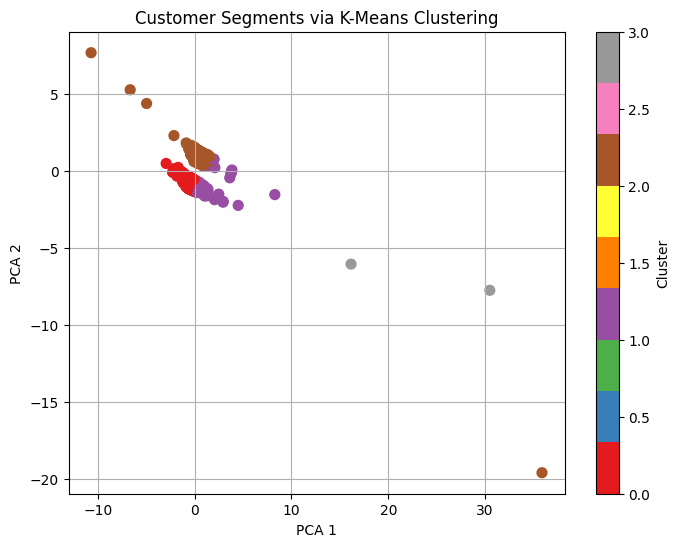


Cluster Profile Summary:
         Quantity UnitPrice CustomerID InvoiceTimestamp                  
            mean      mean    nunique              min         max count
Cluster                                                                 
0          13.12      2.36         94       1291191960  1291224900  1801
1           2.31     12.50         71       1291192440  1291310340   182
2          10.46      2.82        106       1291276080  1291313280  1810
3           1.00    230.00          2       1291199340  1291313160     2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import random

# 1. Load the data
df = pd.read_csv('ecommerce1.csv',encoding='latin-1',nrows=5000)
df = df[['Quantity', 'UnitPrice', 'CustomerID', 'InvoiceDate', 'Country']].dropna()

# Convert InvoiceDate to numerical (timestamp)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceTimestamp'] = df['InvoiceDate'].astype(np.int64) // 10**9
df.drop(columns=['InvoiceDate', 'Country'], inplace=True)

# 2. Normalize the data
features = ['Quantity', 'UnitPrice', 'InvoiceTimestamp']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

# 3. K-Means from scratch
class KMeansScratch:
    def __init__(self, k=3, max_iters=100, tol=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol

    def initialize_centroids(self, data):
        indices = np.random.choice(len(data), self.k, replace=False)
        return data[indices]

    def compute_distances(self, data, centroids):
        return np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)

    def assign_clusters(self, distances):
        return np.argmin(distances, axis=1)

    def update_centroids(self, data, labels):
        return np.array([data[labels == i].mean(axis=0) for i in range(self.k)])

    def fit(self, data):
        self.centroids = self.initialize_centroids(data)
        for _ in range(self.max_iters):
            old_centroids = self.centroids
            distances = self.compute_distances(data, self.centroids)
            self.labels = self.assign_clusters(distances)
            self.centroids = self.update_centroids(data, self.labels)
            if np.all(np.linalg.norm(self.centroids - old_centroids, axis=1) < self.tol):
                break
        return self

    def predict(self, data):
        distances = self.compute_distances(data, self.centroids)
        return self.assign_clusters(distances)

# 4. Apply K-Means
kmeans = KMeansScratch(k=4)
kmeans.fit(scaled_data)
labels = kmeans.labels

# 5. Evaluate with silhouette score
score = silhouette_score(scaled_data, labels)
print(f"Silhouette Score: {score:.3f}")

# 6. Visualize with PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='Set1', s=50)
plt.title('Customer Segments via K-Means Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# 7. Add cluster labels back to original DataFrame
df['Cluster'] = labels

# 8. Profile each cluster
summary = df.groupby('Cluster').agg({
    'Quantity': 'mean',
    'UnitPrice': 'mean',
    'CustomerID': 'nunique',
    'InvoiceTimestamp': ['min', 'max', 'count']
}).round(2)

print("\nCluster Profile Summary:\n", summary)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('ecommerce1.csv',encoding='latin-1',nrows=1000)
df = df[['Quantity', 'UnitPrice', 'CustomerID', 'InvoiceDate', 'Country']].dropna()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceTimestamp'] = df['InvoiceDate'].astype(np.int64) // 10**9
df.drop(columns=['InvoiceDate', 'Country'], inplace=True)

# Normalize features for clustering
features = ['Quantity', 'UnitPrice', 'InvoiceTimestamp']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

# KMeans (assuming 4 clusters found)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10) # Added n_init
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Profile the clusters
cluster_summary = df.groupby('Cluster').agg({
    'Quantity': 'mean',
    'UnitPrice': 'mean',
    'CustomerID': 'nunique',
    'InvoiceTimestamp': ['min', 'max', 'count']
})
print("Cluster Summary:\n", cluster_summary)

# Add labels manually based on profiling (example — adjust as per your results)
cluster_labels = {
    0: 'Frequent Buyer',
    1: 'High Spender',
    2: 'Low Value',
    3: 'New Customer'
}
df['Segment'] = df['Cluster'].map(cluster_labels)

# Prepare data for classifier
X = df[['Quantity', 'UnitPrice', 'InvoiceTimestamp']]
y = df['Segment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier (Random Forest)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test
y_pred = clf.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Cluster Summary:
            Quantity   UnitPrice CustomerID InvoiceTimestamp                  
               mean        mean    nunique              min         max count
Cluster                                                                      
0          7.354934    2.600722         25       1291202460  1291207380   679
1         17.522293    3.502516         24       1291191960  1291200780   314
2        446.400000    1.286000          4       1291197480  1291206420     5
3          1.000000  165.000000          1       1291199340  1291199340     1
Confusion Matrix:
 [[139   0]
 [  0  61]]

Classification Report:
                 precision    recall  f1-score   support

Frequent Buyer       1.00      1.00      1.00       139
  High Spender       1.00      1.00      1.00        61

      accuracy                           1.00       200
     macro avg       1.00      1.00      1.00       200
  weighted avg       1.00      1.00      1.00       200



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from scipy.stats import zscore # Import zscore

df = pd.read_csv('ecommerce1.csv',encoding='latin-1',nrows=5000)

# Remove null CustomerID or Description
df = df.dropna(subset=['CustomerID', 'Description'])

# Remove returns and zero/negative sales
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Create new features
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Time-based features
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['InvoiceDay'] = df['InvoiceDate'].dt.day
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['Weekday'] = df['InvoiceDate'].dt.weekday

# Frequency features
customer_freq = df['CustomerID'].value_counts().to_dict()
df['CustomerFreq'] = df['CustomerID'].map(customer_freq)

# Drop unnecessary
df = df.drop(columns=['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate'])

# Encode Country
le = LabelEncoder()
df['Country'] = le.fit_transform(df['Country'])

# Binary classification — restrict to two countries
df_binary = df[df['Country'] <= 1]

# Features and target
features = ['Quantity', 'UnitPrice', 'TotalPrice', 'InvoiceHour', 'InvoiceDay',
            'InvoiceMonth', 'Weekday', 'CustomerFreq']
target = 'Country'

X = df_binary[features]
y = df_binary[target]

# Remove outliers (z-score) - Temporarily removed as it was causing the dataset to be empty
# X = X[(np.abs(zscore(X)) < 3).all(axis=1)]
# y = y[X.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# ===============================
# 📦 Imports
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

# ===============================
# 📂 Load and Clean Dataset
# ===============================
df = pd.read_csv("ecommerce1.csv", encoding='ISO-8859-1')

df_cleaned = df.dropna(subset=['CustomerID', 'Description'])
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
df_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['UnitPrice'] > 0)]
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']
df_cleaned['InvoiceMonth'] = df_cleaned['InvoiceDate'].dt.month
df_cleaned['Weekday'] = df_cleaned['InvoiceDate'].dt.weekday

features = ['Quantity', 'UnitPrice', 'TotalPrice', 'InvoiceMonth', 'Weekday']
target = 'Country'

le = LabelEncoder()
df_cleaned[target] = le.fit_transform(df_cleaned[target])

df_binary = df_cleaned[df_cleaned[target] <= 1]  # Binary classification (first 2 countries)

X = df_binary[features]
y = df_binary[target]

# ===============================
# ✂️ Train-test split & scaling
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ===============================
# ⚙️ SVM From Scratch
# ===============================
class SVMFromScratch:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

# Train and evaluate SVM
svm = SVMFromScratch()
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
svm_preds = np.where(svm_preds == -1, 0, 1)

svm_acc = accuracy_score(y_test, svm_preds)
print(f"✅ Accuracy (SVM from Scratch): {svm_acc:.2f}")

# ===============================
# 🧠 ANN From Scratch (1 Hidden Layer)
# ===============================


# ===============================
# 📊 Final Comparison
# ===============================
print("\n📊 Final Model Comparison:")
print(f"SVM Accuracy: {svm_acc:.2f}")



<ipython-input-17-985748270>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])


✅ Accuracy (SVM from Scratch): 0.74

📊 Final Model Comparison:
SVM Accuracy: 0.74


In [ ]:
# ===============================
# 🧠 ANN From Scratch (1 Hidden Layer)
# ===============================
class ANNFromScratch:
    def __init__(self, input_size, hidden_size, output_size, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs

        # Weight initialization
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return z * (1 - z)

    def fit(self, X, y):
        # Convert y to a NumPy array before reshaping
        y = y.values.reshape(-1, 1)  # Ensure column vector
        for _ in range(self.epochs):
            # Forward pass
            z1 = np.dot(X, self.W1) + self.b1
            a1 = self.sigmoid(z1)

            z2 = np.dot(a1, self.W2) + self.b2
            a2 = self.sigmoid(z2)

            # Backward pass
            error = y - a2
            d2 = error * self.sigmoid_derivative(a2)
            d1 = d2.dot(self.W2.T) * self.sigmoid_derivative(a1)

            # Update weights
            self.W2 += a1.T.dot(d2) * self.lr
            self.b2 += np.sum(d2, axis=0, keepdims=True) * self.lr
            self.W1 += X.T.dot(d1) * self.lr
            self.b1 += np.sum(d1, axis=0, keepdims=True) * self.lr

    def predict(self, X):
        z1 = np.dot(X, self.W1) + self.b1
        a1 = self.sigmoid(z1)
        z2 = np.dot(a1, self.W2) + self.b2
        a2 = self.sigmoid(z2)
        return (a2 > 0.5).astype(int).flatten()

# Train and evaluate ANN
input_size = X_train.shape[1]
ann = ANNFromScratch(input_size=input_size, hidden_size=10, output_size=1, lr=0.01, epochs=1000)
ann.fit(X_train, y_train)
ann_preds = ann.predict(X_test)

ann_acc = accuracy_score(y_test, ann_preds)
print(f"✅ Accuracy (ANN from Scratch): {ann_acc:.2f}")

# ===============================
# 📊 Final Comparison
# ===============================
print("\n📊 Final Model Comparison:")
print(f"SVM Accuracy: {svm_acc:.2f}")
print(f"ANN Accuracy: {ann_acc:.2f}")

✅ Accuracy (ANN from Scratch): 0.87

📊 Final Model Comparison:
SVM Accuracy: 0.74
ANN Accuracy: 0.87


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


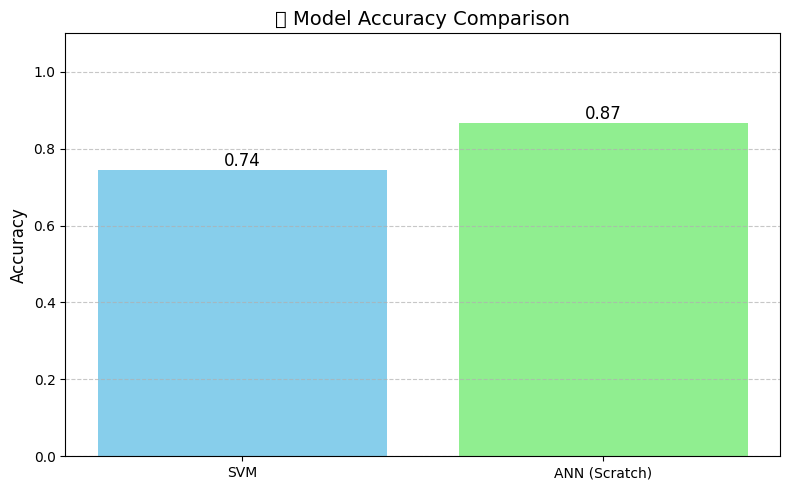

In [ ]:
import matplotlib.pyplot as plt

# Model names and accuracies
models = ['SVM', 'ANN (Scratch)']
accuracies = [svm_acc, ann_acc]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])

# Annotate bars with accuracy values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', fontsize=12)

# Title and labels
plt.title('📊 Model Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.1)  # extend slightly above 1 for spacing
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


<ipython-input-21-53549876>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])


Starting training of the from-scratch model...

Epoch 1/10 - Loss: 0.6050 - Accuracy: 0.8905 - Val_Loss: 0.6067 - Val_Accuracy: 0.8905
Epoch 2/10 - Loss: 0.6012 - Accuracy: 0.8905 - Val_Loss: 0.6023 - Val_Accuracy: 0.8905
Epoch 3/10 - Loss: 0.5843 - Accuracy: 0.8905 - Val_Loss: 0.5851 - Val_Accuracy: 0.8905
Epoch 4/10 - Loss: 0.5698 - Accuracy: 0.8905 - Val_Loss: 0.5709 - Val_Accuracy: 0.8905
Epoch 5/10 - Loss: 0.5758 - Accuracy: 0.8905 - Val_Loss: 0.5766 - Val_Accuracy: 0.8905
Epoch 6/10 - Loss: 0.5646 - Accuracy: 0.8905 - Val_Loss: 0.5652 - Val_Accuracy: 0.8905
Epoch 7/10 - Loss: 0.5641 - Accuracy: 0.8905 - Val_Loss: 0.5649 - Val_Accuracy: 0.8905
Epoch 8/10 - Loss: 0.5626 - Accuracy: 0.8905 - Val_Loss: 0.5633 - Val_Accuracy: 0.8905
Epoch 9/10 - Loss: 0.5654 - Accuracy: 0.8905 - Val_Loss: 0.5659 - Val_Accuracy: 0.8905
Epoch 10/10 - Loss: 0.5575 - Accuracy: 0.8905 - Val_Loss: 0.5585 - Val_Accuracy: 0.8905

Final Test Accuracy: 0.8905
Final Test Loss: 0.5585


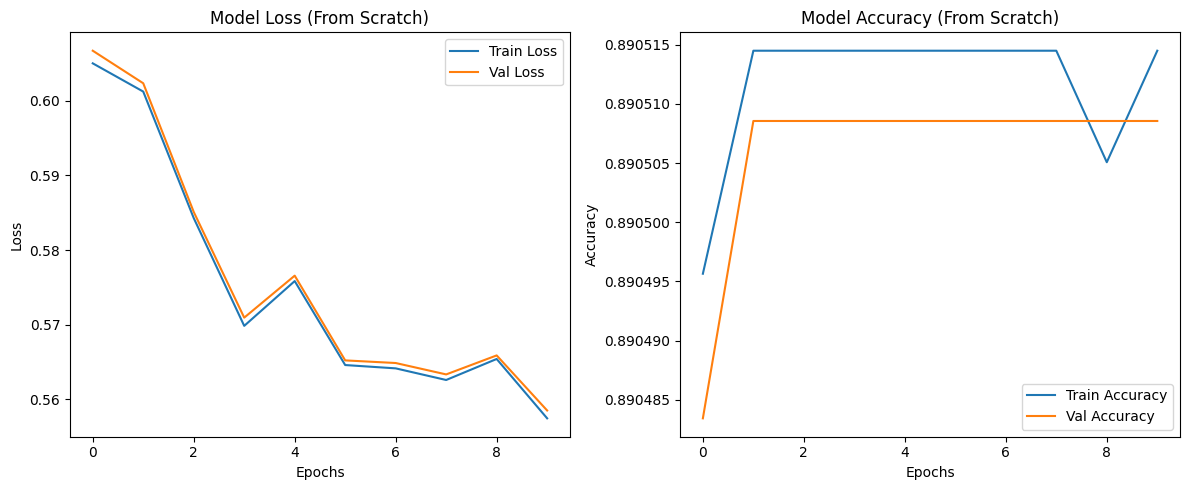

In [21]:
df = pd.read_csv("ecommerce1.csv", encoding="ISO-8859-1")
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ==============================================================================
# 1. DATA PREPROCESSING (Same as your original code)
# ==============================================================================

# Load dataset (after preprocessing)
# Ensure you have the 'ecommerce1.csv' file in the same directory
df = pd.read_csv("ecommerce1.csv", encoding='ISO-8859-1')

# Drop missing values
df_cleaned = df.dropna(subset=['CustomerID', 'Description'])

# Convert InvoiceDate to datetime
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

# Remove negative Quantity & UnitPrice
df_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['UnitPrice'] > 0)]

# Create TotalPrice feature
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

# Extract time-based features
df_cleaned['InvoiceMonth'] = df_cleaned['InvoiceDate'].dt.month
df_cleaned['Weekday'] = df_cleaned['InvoiceDate'].dt.weekday

# Select features and target
features = ['Quantity', 'UnitPrice', 'TotalPrice', 'InvoiceMonth', 'Weekday']
target = 'Country'  # Example: Predicting country

# Encode categorical target variable
le = LabelEncoder()
df_cleaned[target] = le.fit_transform(df_cleaned[target])  # Convert country names to numerical labels

# Extract X (features) and y (target)
X = df_cleaned[features]
y = df_cleaned[target]

# Split into training and test sets (80% train, 20% test)
# Use stratify to ensure proportional representation of countries in train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ==============================================================================
# 2. ANN IMPLEMENTATION FROM SCRATCH USING NUMPY
# ==============================================================================

class ANN_from_scratch:
    """
    A simple Feedforward Neural Network for multi-class classification,
    built from scratch using NumPy.
    """
    def __init__(self, layer_sizes, learning_rate=0.1):
        """
        Initializes the network's weights and biases.
        - layer_sizes: A list of integers specifying the number of neurons in each
                       layer, from input to output. E.g., [5, 32, 16, 8, 37]
        - learning_rate: The step size for gradient descent.
        """
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []

        # Initialize weights and biases for each layer (except the input layer)
        for i in range(len(layer_sizes) - 1):
            # Xavier/Glorot initialization for weights
            limit = np.sqrt(6 / (layer_sizes[i] + layer_sizes[i+1]))
            w = np.random.uniform(-limit, limit, (layer_sizes[i], layer_sizes[i+1]))
            # Initialize biases to zero
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    # --- Activation Functions and their Derivatives ---
    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def softmax(self, Z):
        # Subtract max for numerical stability (to prevent overflow)
        exp_z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    # --- Core Network Functions ---
    def _forward_propagation(self, X):
        """
        Passes input data through the network.
        Returns the final predictions and a cache of intermediate values for backprop.
        """
        caches = {'A': [X], 'Z': []}
        A = X

        # Loop through hidden layers with ReLU activation
        for i in range(len(self.weights) - 1):
            Z = np.dot(A, self.weights[i]) + self.biases[i]
            A = self.relu(Z)
            caches['Z'].append(Z)
            caches['A'].append(A)

        # Output layer with Softmax activation
        Z_out = np.dot(A, self.weights[-1]) + self.biases[-1]
        A_out = self.softmax(Z_out)
        caches['Z'].append(Z_out)
        caches['A'].append(A_out)

        return A_out, caches

    def _compute_loss(self, y_true, y_pred):
        """
        Computes Sparse Categorical Cross-Entropy Loss.
        - y_true: Ground truth labels (e.g., [0, 5, 2])
        - y_pred: Predicted probabilities from softmax
        """
        m = y_true.shape[0]
        # Get the probabilities corresponding to the true class for each example
        correct_logprobs = -np.log(y_pred[range(m), y_true] + 1e-9) # add small epsilon for stability
        loss = np.sum(correct_logprobs) / m
        return loss

    def _backward_propagation(self, y_true, caches):
        """
        Performs backpropagation to calculate gradients of weights and biases.
        """
        m = y_true.shape[0]
        y_pred = caches['A'][-1]

        # --- Start with the output layer ---
        # The derivative of softmax + cross-entropy loss is very simple: y_pred - y_true_one_hot
        dZ = y_pred.copy()
        dZ[range(m), y_true] -= 1
        dZ /= m

        grads = {}
        num_layers = len(self.weights)

        # --- Propagate backwards through all layers ---
        for i in range(num_layers - 1, -1, -1):
            A_prev = caches['A'][i]

            # Gradients for weights and biases of the current layer
            grads[f'dW{i}'] = np.dot(A_prev.T, dZ)
            grads[f'db{i}'] = np.sum(dZ, axis=0, keepdims=True)

            # Gradient for the activation of the previous layer (to continue the chain)
            if i > 0:
                dA_prev = np.dot(dZ, self.weights[i].T)
                # Apply the derivative of the ReLU activation function
                dZ = dA_prev * self.relu_derivative(caches['Z'][i-1])

        return grads

    def _update_parameters(self, grads):
        """
        Updates weights and biases using simple gradient descent.
        """
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads[f'dW{i}']
            self.biases[i] -= self.learning_rate * grads[f'db{i}']

    def fit(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        """
        The main training loop.
        """
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(epochs):
            # Shuffle training data each epoch
            permutation = np.random.permutation(X_train.shape[0])
            X_shuffled = X_train[permutation]
            y_shuffled = y_train[permutation]

            for i in range(0, X_train.shape[0], batch_size):
                # Get mini-batch
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # 1. Forward propagation
                y_pred, caches = self._forward_propagation(X_batch)

                # 2. Backward propagation
                grads = self._backward_propagation(y_batch, caches)

                # 3. Update parameters
                self._update_parameters(grads)

            # --- Evaluate at the end of each epoch ---
            train_loss, train_acc = self.evaluate(X_train, y_train)
            val_loss, val_acc = self.evaluate(X_val, y_val)

            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs} - "
                  f"Loss: {train_loss:.4f} - Accuracy: {train_acc:.4f} - "
                  f"Val_Loss: {val_loss:.4f} - Val_Accuracy: {val_acc:.4f}")

        return history

    def predict(self, X):
        """
        Makes predictions on new data.
        """
        y_pred_probs, _ = self._forward_propagation(X)
        return np.argmax(y_pred_probs, axis=1)

    def evaluate(self, X, y):
        """
        Evaluates the model's loss and accuracy on a given dataset.
        """
        y_pred_probs, _ = self._forward_propagation(X)
        loss = self._compute_loss(y, y_pred_probs)

        y_pred_classes = np.argmax(y_pred_probs, axis=1)
        accuracy = np.mean(y_pred_classes == y)

        return loss, accuracy

# ==============================================================================
# 3. BUILD, TRAIN, AND EVALUATE THE FROM-SCRATCH MODEL
# ==============================================================================

# Define model architecture based on the original Keras model
input_size = X_train.shape[1]
num_classes = len(le.classes_)
layer_sizes = [input_size, 32, 16, 8, num_classes]

# Instantiate and train the model
# NOTE: A slightly higher learning rate and more epochs might be needed for a
# from-scratch model with simple SGD to catch up to an Adam optimizer.
# Let's start with 10 epochs as requested.
model_scratch = ANN_from_scratch(layer_sizes, learning_rate=0.1)

print("Starting training of the from-scratch model...\n")
# We pass y_test as a numpy array for easier indexing
history = model_scratch.fit(X_train, y_train.to_numpy(), X_test, y_test.to_numpy(), epochs=10, batch_size=32)

# Evaluate final model on Test Data
test_loss, test_acc = model_scratch.evaluate(X_test, y_test.to_numpy())
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

# ==============================================================================
# 4. PLOT TRAINING HISTORY
# ==============================================================================

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss (From Scratch)')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy (From Scratch)')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:

import pandas as pd

# Assuming 'df' is your DataFrame (loaded from "ecommerce1.csv")
# Convert InvoiceDate to datetime if it's not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Date'] = df['InvoiceDate'].dt.date  # Keep only the date

# Create 'TotalPrice' column if it doesn't exist
if 'TotalPrice' not in df.columns:
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Create 'HighValueOrder' column based on TotalPrice (adjust threshold as needed)
df['HighValueOrder'] = df['TotalPrice'].apply(lambda x: 1 if x > 100 else 0)

# Aggregate: count high and low orders per day
daily_trend = df.groupby(['Date', 'HighValueOrder']).size().unstack(fill_value=0)
daily_trend.columns = ['LowOrders', 'HighOrders']
daily_trend = daily_trend.reset_index()

# Display the result
print(daily_trend)

           Date  LowOrders  HighOrders
0    2010-12-01       3027          81
1    2010-12-02       2043          66
2    2010-12-03       2124          78
3    2010-12-05       2694          31
4    2010-12-06       3834          44
..          ...        ...         ...
300  2011-12-05       5241          90
301  2011-12-06       3282          83
302  2011-12-07       2339          99
303  2011-12-08       4864          76
304  2011-12-09       1595          37

[305 rows x 3 columns]
